In [ ]:
#default_exp train

In [ ]:
#export
import os
import torch

import pandas as pd
import numpy as np

import Bert4NER.config as config
import Bert4NER.model.model as model
import Bert4NER.utils.utils as utils
import Bert4NER.utils.engine as engine
import Bert4NER.dataset.dataset as dataset


from functools import partial
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from transformers import AdamW, get_linear_schedule_with_warmup

In [ ]:
SEED = 42
utils.seed_everything(SEED)

In [ ]:
#hide
df = pd.read_csv(config.DATA_PATH/'ner_datasetreference.csv', encoding='latin-1')
df.head()

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O


We use the foward fill method in pandas to fill all the nans for the each sentence in the `Sentence #` column.

In [ ]:
#hide
df['Sentence #'].fillna(method='ffill')

0              Sentence: 1
1              Sentence: 1
2              Sentence: 1
3              Sentence: 1
4              Sentence: 1
                ...       
1048570    Sentence: 47959
1048571    Sentence: 47959
1048572    Sentence: 47959
1048573    Sentence: 47959
1048574    Sentence: 47959
Name: Sentence #, Length: 1048575, dtype: object

In [ ]:
#export
df['Sentence #'] = df['Sentence #'].fillna(method='ffill')

In total we cans ee that there are 47959 sentences in our dataset

In [ ]:
#hide
len(df['Sentence #'].unique())

47959

Now let us encode all the labels for every word in every sentence

In [ ]:
#hide
le_pos = LabelEncoder()
le_tag = LabelEncoder()

In [ ]:
#export
utils.save_label_encoders(le_tag=le_tag, le_pos=le_pos)

files saved!


In [ ]:
#export
le_pos, le_tag = utils.load_label_encoders()

In [ ]:
#hide
df["encoded_POS"] = le_pos.fit_transform(df.POS)
df["encoded_Tag"] = le_tag.fit_transform(df.Tag)

In [ ]:
#export
sentences, tags, pos = utils.process_data(df)

In [ ]:
sentences = sentences[:100]
tags = tags[:100]
pos = pos[:100]

In [ ]:
#hide
len(sentences), len(tags), len(pos)

(100, 100, 100)

## data Split

I'll be using a simple train-test split

In [ ]:
#export
train_sentences, valid_sentences, train_tag, valid_tag, train_pos, valid_pos = train_test_split(sentences, tags, pos, test_size=0.1)

In [ ]:
#export
train_dl = utils.create_loader(train_sentences, train_tag, train_pos, bs=config.TRAIN_BATCH_SIZE)
valid_dl = utils.create_loader(valid_sentences, valid_tag, valid_pos, bs=config.TRAIN_BATCH_SIZE)

In [ ]:
#export
modeller = model.EntityModel(len(le_tag.classes_), len(le_pos.classes_))

In [ ]:
#export
model_params = list(modeller.named_parameters())

In [ ]:
#export
# we don't want weight decay for these
no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.bias']

optimizer_params = [
    {'params': [p for n, p in model_params if n not in no_decay], 
    'weight_decay':0.001},
    #  no weight decay should be applied
    {'params': [p for n, p in model_params if n in no_decay],
    'weight_decay':0.0}
]

In [ ]:
#export
lr = config.LR

In [ ]:
#export
optimizer = AdamW(optimizer_params, lr=lr)

In [ ]:
#export
num_train_steps = int(len(df) / config.TRAIN_BATCH_SIZE * config.NUM_EPOCHS)

In [ ]:
#export
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, 
                                                num_warmup_steps=0, 
                                                num_training_steps=num_train_steps)

In [ ]:
#export
fit = engine.BertFitter(modeller, (train_dl, valid_dl), optimizer, [accuracy_score, partial(f1_score, average='macro')], config.DEVICE, scheduler=scheduler, log_file='training_log.txt')

epoch,train_loss,valid_loss,metric1,metric2,time
1,3.166808,2.991318,0.144355,0.000445,0:0:16
2,3.393228,5.656225,0.325806,0.003110,0:0:7
3,3.104125,8.032919,0.507258,0.008096,0:0:7
4,2.820689,10.251463,0.688710,0.012660,0:0:7
5,2.643444,12.347538,0.870161,0.017441,0:0:7
6,2.498829,14.316296,1.051613,0.024538,0:0:7


all_metric_0: [0.16129032258064516, 0.056451612903225805, 0.12903225806451613, 0.1774193548387097, 0.13709677419354838, 0.11290322580645161, 0.16129032258064516, 0.1693548387096774, 0.21774193548387097, 0.12096774193548387]
all_metric_1: [0.0, 0.002364066193853428, 0.015513897866839044, 0.0, 0.002285714285714286, 0.0045351473922902496, 0.0, 0.0030303030303030303, 0.02546777546777547, 0.0019841269841269845]


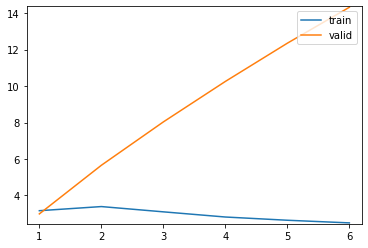

all_metric_0: [0.1774193548387097, 0.07258064516129033, 0.18548387096774194, 0.20161290322580644, 0.25806451612903225, 0.12096774193548387, 0.1693548387096774, 0.1935483870967742, 0.2661290322580645, 0.1693548387096774]
all_metric_1: [0.05365371955233707, 0.007490636704119849, 0.01367461430575035, 0.08994708994708994, 0.03520074696545285, 0.00980392156862745, 0.025883838383838384, 0.038922841864018336, 0.03009259259259259, 0.02574916759156493]
all_metric_0: [0.1774193548387097, 0.07258064516129033, 0.18548387096774194, 0.20161290322580644, 0.25806451612903225, 0.12096774193548387, 0.1693548387096774, 0.1935483870967742, 0.2661290322580645, 0.1693548387096774]
all_metric_1: [0.05668934240362812, 0.012213740458015269, 0.016565656565656565, 0.12040816326530612, 0.07028571428571428, 0.0546448087431694, 0.054899862042719176, 0.031794871794871796, 0.09863883847549909, 0.10222222222222223]
all_metric_0: [0.1774193548387097, 0.07258064516129033, 0.18548387096774194, 0.20161290322580644, 0.2580

In [ ]:
#export
NUM_EPOCHS = 6
fit.fit(NUM_EPOCHS, model_path=os.path.join(config.MODEL_PATH/'ner_model.pth'))